In [36]:
import numpy as np, pandas as pd, scanpy as sc, matplotlib.pyplot as plt, os
from scipy.stats import hypergeom
import celloracle as co, glob, pickle
from functools import reduce
import itertools, math, random
import networkx as nx

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'lf_enrich')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"
random.seed(42)

#### Extract used weight dataframe from the pickle object

In [44]:
import pickle
cluster_fusion = ('3','7')
experiment = 'PRDM1_KO'
ord_tf = 1
suffix = f"_{experiment}"
with open(f"{out_path}/out_files/SLIDE_LF_enrichment/cc_dict_{ord_tf}_TFs_{cluster_fusion}{suffix}.pickle", "rb") as f:
    cc_dict = pickle.load(f)

In [45]:
concatenated_df = pd.DataFrame()
for i in range(len(cc_dict[cluster_fusion][ord_tf])):
    used_weight_df = cc_dict[cluster_fusion][ord_tf][i][5][1]
    if used_weight_df.empty:
        continue
    used_weight_df['case'] = cc_dict[cluster_fusion][ord_tf][i][4]
    concatenated_df = pd.concat([concatenated_df, used_weight_df], ignore_index=True)
concatenated_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/{ord_tf}_TFs_{cluster_fusion}{suffix}_used_weights.csv", index=False)


#### Create the data for slide GRN which intersects the edges from SLIDE and used weights

In [46]:
import ast
slide_lf_enriched = pd.read_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/enriched_df_{ord_tf}_TFs_{cluster_fusion}{suffix}.csv")
used_weight_df = pd.read_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/{ord_tf}_TFs_{cluster_fusion}{suffix}_used_weights.csv")
slide_lf_enriched = slide_lf_enriched[slide_lf_enriched['case']=='slide']
used_weight_df = used_weight_df[used_weight_df['case']=='slide']

slide_lf_enriched = slide_lf_enriched[['TF', 'common']]
slide_lf_enriched['TF'] = slide_lf_enriched['TF'].apply(ast.literal_eval).apply(tuple)
slide_lf_enriched['common'] = slide_lf_enriched['common'].apply(ast.literal_eval).apply(list)
slide_lf_enriched = slide_lf_enriched.explode('common')
slide_lf_enriched = slide_lf_enriched.explode('TF')
slide_lf_enriched.columns = ['source', 'target']
used_weight_df = used_weight_df[used_weight_df['case']=='slide']
used_weight_df = used_weight_df[used_weight_df['strength']==1]
slide_lf_enriched = slide_lf_enriched.merge(used_weight_df, on=['source', 'target'], how='left')
slide_lf_enriched.to_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/enriched_df_{ord_tf}_TFs_{cluster_fusion}{suffix}_used_weights_strong.csv", index=False)

In [47]:
fig = slide_lf_enriched.groupby(['strength', 'key']).size().unstack().plot(kind='bar', stacked=True)
# fig = slide_lf_enriched.groupby(['strength', 'key']).plot(kind='bar', stacked=True)
plt.xlabel('Strength')
plt.ylabel('Count')
plt.title('Distribution of Key and Strength')
plt.savefig(f"{out_path}/figures/enriched_key_strength_{ord_tf}_TFs_{cluster_fusion}{suffix}_used_weights_strong.pdf")
plt.close()

#### Create the enrichment plot for single TF enrichment

In [48]:
def read_slide_data(experiment, wd):
    feature_files = glob.glob(f"{wd}/out_data/out_other_methods/SLIDE_Runs/{experiment}/*/*feature_list*")
    if experiment == 'IRF4_KO':
        feature_data = [pd.read_csv(file, sep='\t', header=0) for file in feature_files if 'Z4' in file or 'Z36' in file]
    else:
        feature_data = [pd.read_csv(file, sep='\t', header = 0) for file in feature_files]
    feature_data = pd.concat(feature_data)
    positive_corr_names = set(feature_data[feature_data['corrs'] >= 0]['names'])
    negative_corr_names = set(feature_data[feature_data['corrs'] < 0]['names'])
    return positive_corr_names, negative_corr_names


positive_corr_names, negative_corr_names = read_slide_data(experiment, wd)


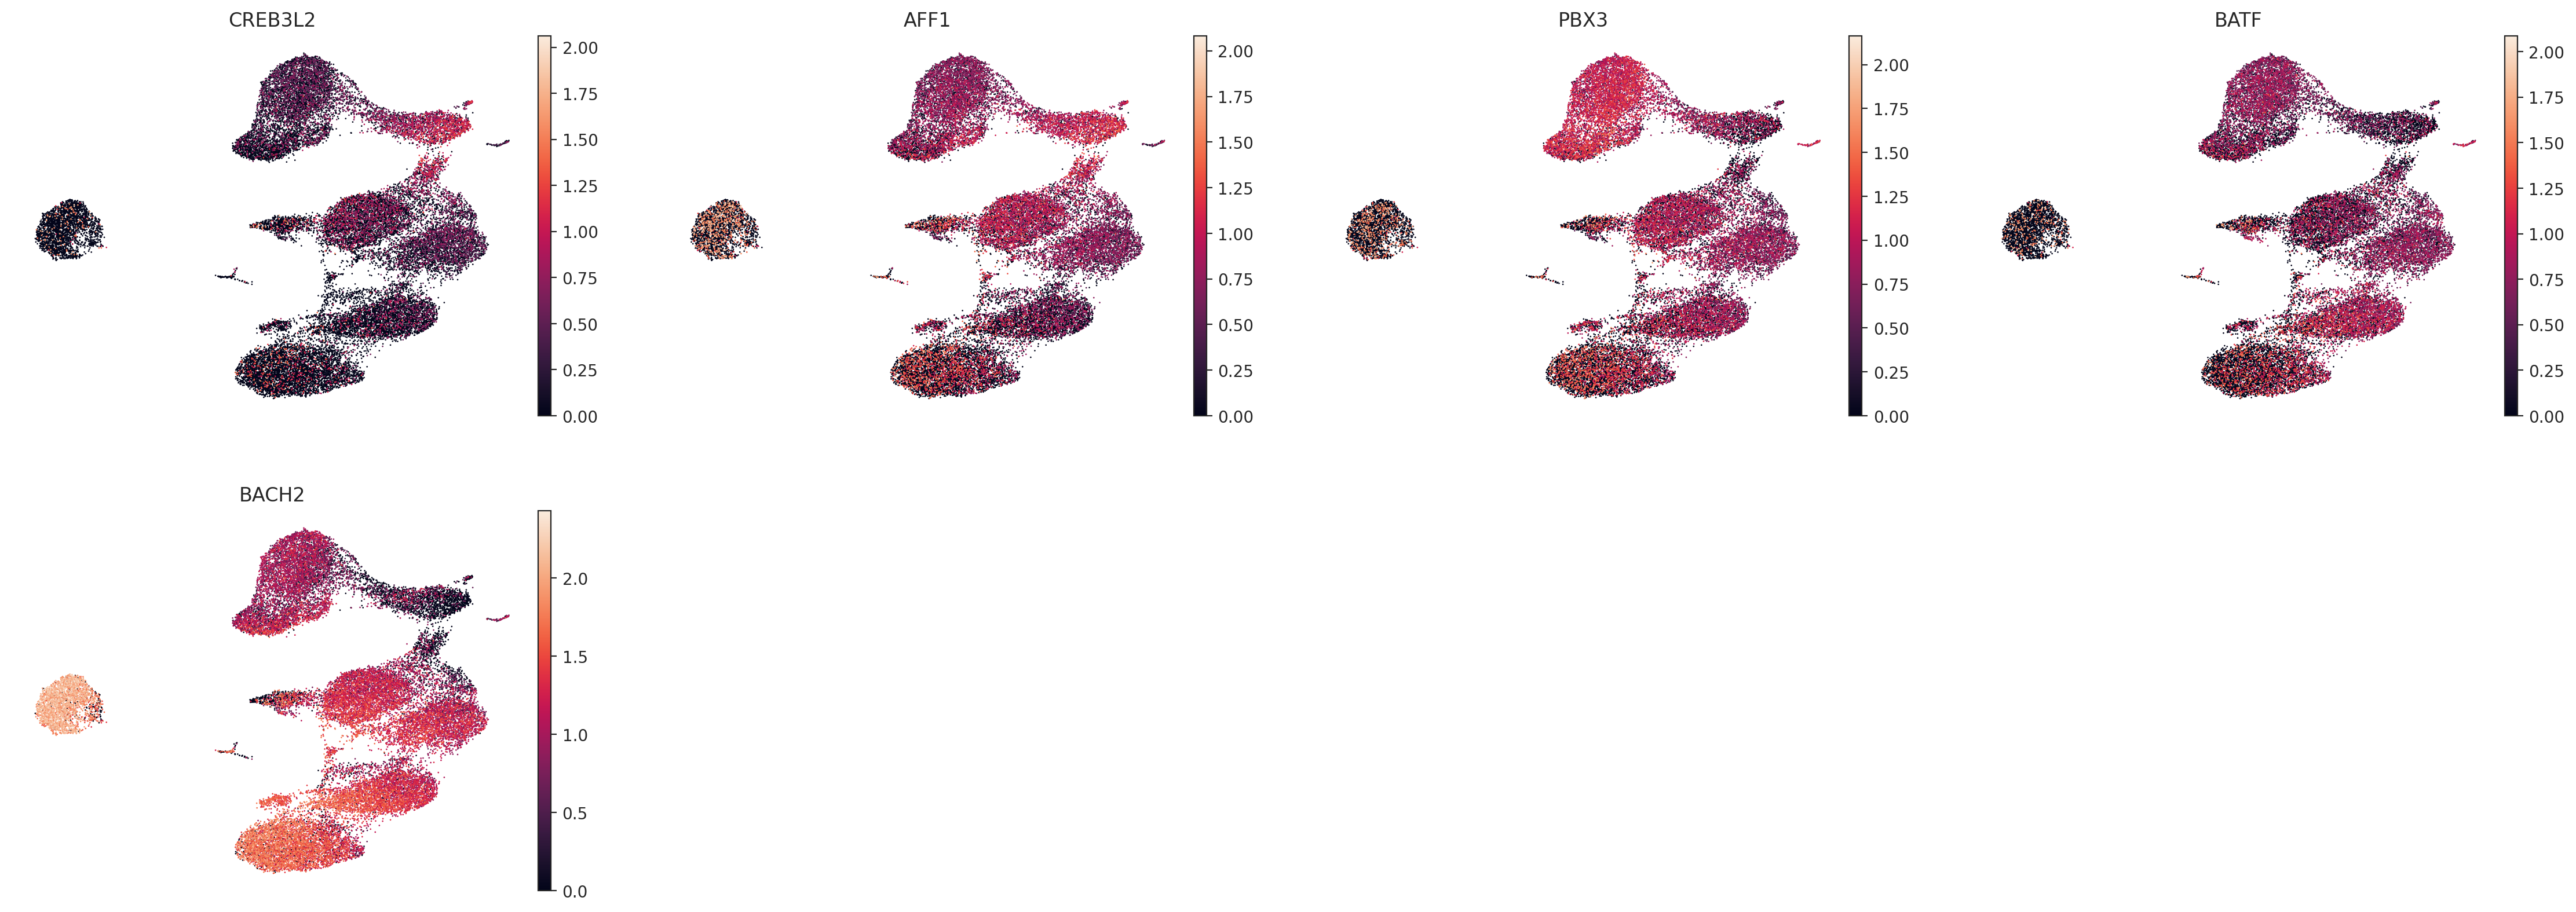

In [23]:
path_to_adata = os.path.join(wd, 'out_data',f'sc_preproc/out_files/male_sc_processed.h5ad')
adata = sc.read_h5ad(path_to_adata)
sc.pl.umap(adata=adata, color=['CREB3L2', 'AFF1', 'PBX3', 'BATF', 'BACH2'], frameon=False,)

In [49]:
import plotly.express as px
import pandas as pd

# Compute color proportions per TF
slide_lf_enriched['color'] = slide_lf_enriched['target'].apply(lambda gene: 'red' if gene in positive_corr_names else ('green' if gene in negative_corr_names else 'gray'))
color_histcounts = slide_lf_enriched.groupby('source')['color'].value_counts(normalize=True).unstack(fill_value=0)

# Initialize score map
tf_name_score = {key: None for key in color_histcounts.index.values}

# Fill score map
for entry in cc_dict[cluster_fusion][ord_tf]:
    tf, cond, score_val = entry[0][0], entry[1], entry[2][0]
    if tf in tf_name_score and cond == (1,):
        tf_name_score[tf] = score_val

# Filter and sort by score
sorted_data = sorted(
    [(v, k) for k, v in tf_name_score.items() if v is not None],
    reverse=True,
    key=lambda x: x[0]
)
if not sorted_data:
    raise ValueError("No valid TF scores found for plotting.")

score, tf_name = zip(*sorted_data)
score_series = pd.Series(score, index=tf_name, name='score')

# Subset color proportions in sorted TF order
color_proportions = color_histcounts.loc[list(tf_name)]

# Save original proportions for annotation
original_props = color_proportions.copy()

# Scale each color proportion by the score (so bar height = score)
scaled = color_proportions.mul(score_series, axis=0).reset_index()
scaled = scaled.rename(columns={'index': 'source'})

# Melt both DataFrames
melted_scaled = scaled.melt(id_vars='source', var_name='color', value_name='height')
melted_props = original_props.reset_index().melt(id_vars='source', var_name='color', value_name='proportion')

# Merge both for text labels
plot_df = melted_scaled.merge(melted_props, on=['source', 'color'])

# Format the text as percentages
plot_df['text'] = (plot_df['proportion'] * 100).round(1).astype(str) + '%'

# Plot
fig = px.bar(
    plot_df,
    x='source',
    y='height',
    color='color',
    text='text',  # <- Add text here
    labels={'height': 'Score-scaled Proportion', 'source': 'TF'},
    title=f'TF Enrichment Scores with color Proportions for {experiment} - {cluster_fusion} - {ord_tf} Order'
)

# Improve text visibility inside bars
fig.update_traces(textposition='inside', insidetextanchor='middle')

# Layout tweaks
fig.update_layout(
    xaxis_title='Transcription Factor (TF)',
    yaxis_title='Enrichment Score',
    xaxis_tickangle=-90,
    font=dict(family="Arial", size=8, color="black"),
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="white",
    xaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside'),
    yaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside')
)

fig.show()
fig.write_image(f"{out_path}/figures/TF_Enrichment_Scores_with_color_Proportions_{ord_tf}_TFs_{cluster_fusion}_{experiment}.svg", format='svg')

#### Making Cliff's delta scatter plots for order 1 and order 2

In [30]:
import ast
cluster_fusion = ('7', '3')
experiment = 'GC_PB'
ord_tf = 2
enrichment_df= pd.read_csv(f"{out_path}/out_files/SLIDE_LF_enrichment/enriched_df_{ord_tf}_TFs_{cluster_fusion}_{experiment}.csv")
enrichment_df['TF'] = enrichment_df['TF'].apply(ast.literal_eval).apply(lambda x: tuple(sorted(x)))
enrichment_df['condition'] = enrichment_df['condition'].apply(ast.literal_eval).apply(tuple)
enrichment_df['common'] = enrichment_df['common'].apply(ast.literal_eval).apply(list)
enrichment_df['dwnstrm'] = enrichment_df['dwnstrm'].apply(ast.literal_eval).apply(list)
enrichment_df = enrichment_df[(enrichment_df['score']>0) & (enrichment_df['p_value']<0.05)]
enrichment_df = enrichment_df[enrichment_df['condition'].isin([(1,1), (1,0), (0,1)])]


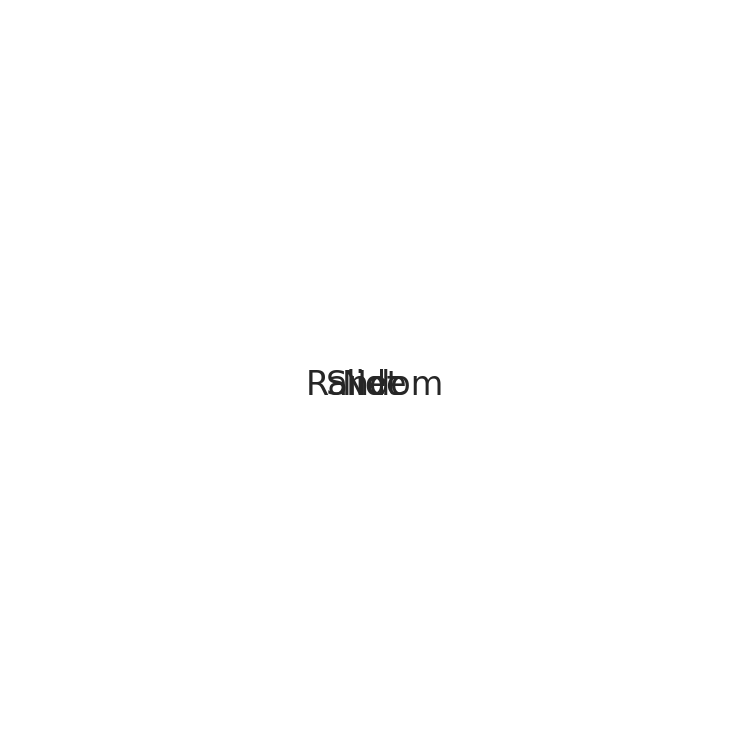

In [31]:
from matplotlib_venn import venn3

slide_pairs = set(enrichment_df[enrichment_df['case']=='slide']['TF'].to_list())
net_pairs = set(enrichment_df[enrichment_df['case']=='net']['TF'].to_list())
rnd_pairs = set(enrichment_df[enrichment_df['case']=='rnd']['TF'].to_list())
# Create a Venn diagram for the three sets
venn = venn3([slide_pairs, net_pairs, rnd_pairs], ('Slide', 'Net', 'Random'))

# Customize the plot
plt.savefig(f"{out_path}/figures/Venn_Diagram_TF_Pairs_{ord_tf}_TFs_{cluster_fusion}_{experiment}.svg", format='svg')
plt.show()

In [29]:
common_pairs

{('AFF1', 'BACH2'),
 ('AFF1', 'CREB3L2'),
 ('AFF1', 'EBF1'),
 ('AFF1', 'ESR1'),
 ('AFF1', 'HERPUD1'),
 ('AFF1', 'HIVEP3'),
 ('AFF1', 'MEF2C'),
 ('AFF1', 'PAX5'),
 ('AFF1', 'RUNX2'),
 ('AFF1', 'SP3'),
 ('AFF1', 'TCF12'),
 ('AFF1', 'XBP1'),
 ('ARID5B', 'BBX'),
 ('ARID5B', 'BHLHE41'),
 ('ARID5B', 'CREB3L2'),
 ('ARID5B', 'FOSB'),
 ('ARID5B', 'HERPUD1'),
 ('ARID5B', 'IRF8'),
 ('ARID5B', 'KLF2'),
 ('ARID5B', 'NFATC2'),
 ('ARID5B', 'NR6A1'),
 ('ARID5B', 'PHF21A'),
 ('ARID5B', 'PLAGL1'),
 ('ARID5B', 'POLR2A'),
 ('ARID5B', 'RFX3'),
 ('ARID5B', 'TCF12'),
 ('ARID5B', 'TFEC'),
 ('ARID5B', 'TGIF1'),
 ('ARID5B', 'THRB'),
 ('ARID5B', 'XBP1'),
 ('ATF3', 'XBP1'),
 ('ATF5', 'CREB3L2'),
 ('ATF5', 'HERPUD1'),
 ('ATF5', 'TFEC'),
 ('ATF7', 'CREB3L2'),
 ('BACH2', 'BATF'),
 ('BACH2', 'BHLHE41'),
 ('BACH2', 'CREB3L2'),
 ('BACH2', 'EBF1'),
 ('BACH2', 'FOXP1'),
 ('BACH2', 'HERPUD1'),
 ('BACH2', 'ID2'),
 ('BACH2', 'IKZF1'),
 ('BACH2', 'KLF7'),
 ('BACH2', 'MEF2A'),
 ('BACH2', 'MEF2C'),
 ('BACH2', 'PHF21A'),
 ('BAC

In [28]:
common_pairs = slide_pairs.intersection(net_pairs)
print((slide_pairs-common_pairs), '\n',(net_pairs-common_pairs), '\n', (rnd_pairs-common_pairs))

{('CREB3L2', 'ZFY')} 
 set() 
 set()


In [65]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

common_pairs = slide_pairs.intersection(net_pairs)
enrichment_df = enrichment_df[~enrichment_df['TF'].isin(common_pairs)]
slide_scores = enrichment_df[enrichment_df['case'] == 'slide']['score']
net_scores = enrichment_df[enrichment_df['case'] == 'net']['score']
# rnd_scores = enrichment_df[enrichment_df['case'] == 'rnd']['score']

def cliffs_delta(x, y):
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return (2 * u) / (n1 * n2) - 1

def compare_nonzero(x, y):
    x_nz, y_nz = x[x != 0], y[y != 0]
    # print(f"Non-zero counts: x={len(x_nz)}, y={len(y_nz)}")
    if len(x_nz) == 0 or len(y_nz) == 0:
        print('error')
        return np.nan, np.nan
    u, p = mannwhitneyu(x_nz, y_nz, alternative='two-sided')
    delta = cliffs_delta(x_nz, y_nz)
    return p, delta

def nonzero_rate(x):
    return np.count_nonzero(x) / len(x)

def compare_distributions(slide, net, rnd):
    groups = {'slide': slide, 'net': net, 'rnd': rnd}
    results = []

    pairs = [('slide', 'net'), ('slide', 'rnd'), ('net', 'rnd')]

    for a, b in pairs:
        x, y = groups[a], groups[b]
        p, delta = compare_nonzero(x, y)
        nz_x, nz_y = nonzero_rate(x), nonzero_rate(y)
        mean_nz = np.min([nz_x, nz_y])
        weighted_delta = delta * mean_nz if not np.isnan(delta) else np.nan
        results.append({
            'Group A': a,
            'Group B': b,
            'Size A': len(x),
            'Size B': len(y),
            'Non-zero A': np.count_nonzero(x),
            'Non-zero B': np.count_nonzero(y),
            'Non-zero Rate A': round(nz_x, 4),
            'Non-zero Rate B': round(nz_y, 4),
            'Mann–Whitney p': round(p, 4) if p is not None else np.nan,
            "Cliff's delta": round(delta, 4) if delta is not None else np.nan,
            'Weighted delta': round(weighted_delta, 4) if weighted_delta is not None else np.nan
        })

    return pd.DataFrame(results)

summary = compare_distributions(slide_scores, net_scores, rnd_scores)
print(f"Combinatorial control for {experiment} and {cluster_fusion} and {order_of_combination} TFs")
print(summary)

error


ZeroDivisionError: division by zero

In [5]:
import plotly.express as px

summary['Group Pair'] = summary['Group A'] + ' vs ' + summary['Group B']
summary["Cliff Size"] = (summary["Cliff's delta"].abs() * 100).round(1)
# Create a scatter plot using Plotly
fig = px.scatter(
    summary,
    x="Group Pair",
    y="Weighted delta",
    size="Cliff Size",
    color="Mann–Whitney p",
    text="Cliff's delta",
    title=f"Cliff's Delta for Group Comparisons for {experiment} - {cluster_fusion} - {order_of_combination} TFs",
    labels={
        "Cliff Size": "Cliff's Δ × 100",
        "Weighted delta": "Weighted Δ",
        "Mann–Whitney p": "Mann–Whitney p-value"
    }
)

# Add a dashed black line at x=0
fig.add_shape(
    type="line",
    x0=-0.5,  # Adjust to align with the x-axis
    x1=2.5,   # Adjust to align with the x-axis
    y0=0,
    y1=0,
    line=dict(color="black", width=1, dash="dash",),
    xref="x",
    yref="y"
)
# Update layout for better visualization
fig.update_layout(
    xaxis_title="Group Pair",
    yaxis_title="Weighted Delta",
    xaxis_tickangle=-90,
    font=dict(family="Arial", size=8, color="black"),
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside', showticklabels=True),
    yaxis=dict(showgrid=False, showline=True, linecolor='black', ticks='outside', showticklabels=True)
)

# Show the plot
fig.show()
fig.write_image(f"{out_path}/figures/Cliffs_Delta_{order_of_combination}_TFs_{cluster_fusion}_{experiment}.svg", format='svg')